<a href="https://colab.research.google.com/github/Shivdutta/AdvanceCNN/blob/master/Pred_CiFAR10_Fashion_classification_resnet50_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
#from keras.applications.vgg16 import VGG16, preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report
from imutils import paths


In [21]:
tf.__version__

'2.2.0-rc3'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

!unzip -q "/content/gdrive/My Drive/CNN_Images/VGG_class_data.zip"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [40]:
!ls /content/data/train

backpack  footwear  glasses  watch


In [0]:
#Give dataset path
trainpath = "/content/data/train/"
testpath = "/content/data/test/"
classes = 4
Image_Size =128
batch_size=20

INIT_LR = 1e-4
BS = 32
NUM_EPOCHS = 20
# define the path to the serialized output model after training
MODEL_PATH = "fashion_resnet.model"


In [0]:
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


In [0]:
#baseModel.summary()

In [0]:
# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=25,
	zoom_range=0.1,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.2,
	horizontal_flip=True,
	fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [53]:
# initialize the training generator
trainGen = trainAug.flow_from_directory(
	trainpath,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=True,
	batch_size=BS)
# initialize the validation generator
valGen = valAug.flow_from_directory(
	testpath,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)
# initialize the testing generator
testGen = valAug.flow_from_directory(
	testpath,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

Found 475 images belonging to 4 classes.
Found 264 images belonging to 4 classes.
Found 264 images belonging to 4 classes.


In [54]:
# load the ResNet-50 network, ensuring the head FC layer sets are left
# off
print("[INFO] preparing model...")
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(classes, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False

[INFO] preparing model...


In [55]:
# compile the model
opt = Adam(lr=INIT_LR, decay=INIT_LR / NUM_EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,	metrics=["accuracy"])
# train the model
print("[INFO] training model...")
H = model.fit_generator(
	trainGen,
	steps_per_epoch=len(list(paths.list_files(trainpath))) // BS,
	validation_data=valGen,
	validation_steps=len(list(paths.list_files(testpath))) // BS,
	epochs=NUM_EPOCHS)

[INFO] training model...
Epoch 1/20
 2/14 [===>..........................] - ETA: 5s - loss: 2.2907 - accuracy: 0.2500

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


14/14 [==============================] - 15s 1s/step - loss: 1.3809 - accuracy: 0.4576 - val_loss: 0.5700 - val_accuracy: 0.8242
Epoch 2/20
14/14 [==============================] - 15s 1s/step - loss: 0.5856 - accuracy: 0.7901 - val_loss: 0.2882 - val_accuracy: 0.9258
Epoch 3/20
14/14 [==============================] - 14s 1s/step - loss: 0.3829 - accuracy: 0.8804 - val_loss: 0.2073 - val_accuracy: 0.9414
Epoch 4/20
14/14 [==============================] - 15s 1s/step - loss: 0.2669 - accuracy: 0.9210 - val_loss: 0.1734 - val_accuracy: 0.9609
Epoch 5/20
14/14 [==============================] - 14s 986ms/step - loss: 0.2086 - accuracy: 0.9300 - val_loss: 0.1545 - val_accuracy: 0.9609
Epoch 6/20
14/14 [==============================] - 15s 1s/step - loss: 0.1548 - accuracy: 0.9549 - val_loss: 0.1525 - val_accuracy: 0.9648
Epoch 7/20
14/14 [==============================] - 15s 1s/step - loss: 0.1440 - accuracy: 0.9661 - val_loss: 0.1370 - val_accuracy: 0.9648
Epoch 8/20
14/14 [==========

In [56]:
# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating network...")
testGen.reset()
predIdxs = model.predict_generator(testGen,	steps=(len(list(paths.list_files(testpath))) // BS) + 1)
predIdxs

[INFO] evaluating network...


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


array([[9.99868870e-01, 5.67904899e-05, 3.23794557e-05, 4.20259057e-05],
       [9.72639799e-01, 4.82106334e-05, 5.99928107e-03, 2.13126689e-02],
       [9.82567251e-01, 2.59430637e-03, 1.26306002e-03, 1.35753416e-02],
       ...,
       [8.22721422e-03, 1.34591106e-03, 5.15790703e-03, 9.85268891e-01],
       [1.90365663e-05, 6.63738174e-04, 1.01372054e-04, 9.99215841e-01],
       [8.49278695e-06, 3.28584633e-07, 3.45501235e-06, 9.99987721e-01]],
      dtype=float32)

In [57]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
predIdxs

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3])

In [58]:
# show a nicely formatted classification report
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))
# serialize the model to disk
print("[INFO] saving model...")
model.save(MODEL_PATH, save_format="h5")

              precision    recall  f1-score   support

    backpack       0.98      0.97      0.98        66
    footwear       0.96      1.00      0.98        66
     glasses       1.00      0.95      0.98        66
       watch       0.97      0.98      0.98        66

    accuracy                           0.98       264
   macro avg       0.98      0.98      0.98       264
weighted avg       0.98      0.98      0.98       264

[INFO] saving model...


In [0]:
model_loaded = tf.keras.models.load_model(MODEL_PATH)

In [60]:
testGen.class_indices.keys()

dict_keys(['backpack', 'footwear', 'glasses', 'watch'])

In [61]:
!ls /content/data/train/watch

00000009.png  00000233.jpg  00000255.jpg  00000280.jpg	00000304.jpg
00000017.png  00000234.jpg  00000256.jpg  00000281.jpg	00000306.jpg
00000036.png  00000235.jpg  00000257.jpg  00000282.jpg	00000307.jpg
00000047.png  00000236.jpg  00000258.jpg  00000283.jpg	00000308.png
00000052.png  00000237.jpg  00000259.jpg  00000284.jpg	00000309.jpg
00000056.png  00000238.jpg  00000261.jpg  00000285.jpg	00000312.jpg
00000058.png  00000239.jpg  00000262.jpg  00000286.jpg	00000313.jpg
00000068.png  00000240.jpg  00000263.jpg  00000288.jpg	00000315.jpg
00000078.png  00000241.jpg  00000264.jpg  00000289.jpg	00000316.jpg
00000086.png  00000242.jpg  00000265.jpg  00000290.jpg	00000317.jpg
00000093.png  00000243.jpg  00000266.jpg  00000291.jpg	00000318.png
00000096.png  00000244.jpg  00000267.jpg  00000292.jpg	00000319.jpg
00000140.png  00000245.jpg  00000268.jpg  00000293.png	00000320.jpg
00000158.png  00000246.jpg  00000269.jpg  00000294.jpg	00000321.jpg
00000166.png  00000247.jpg  00000271.jpg  000002

Input Dimensions - Image :  (128, 128, 3)


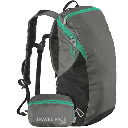

None
dict_keys(['backpack', 'footwear', 'glasses', 'watch'])
[[0.08856989 0.03060208 0.70783997 0.17298812]]


In [63]:
from matplotlib.pyplot import imshow
import cv2
from google.colab.patches import cv2_imshow
from skimage import io

input_img_o= "/content/data/test/backpack/00000214.png"
input_img = io.imread(input_img_o)
input_img = cv2.resize(input_img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
print('Input Dimensions - Image : ',input_img.shape)
print(cv2_imshow(input_img))

#Reference https://stackoverflow.com/questions/43017017/keras-model-predict-for-a-single-image
#Since you trained your model on mini-batches, your input is a tensor of shape [batch_size, image_width, image_height, number_of_channels].
#When predicting, you have to respect this shape even if you have only one image. Your input should be of shape: [1, image_width, image_height, number_of_channels].

from PIL import Image
#import numpy as np
from skimage import transform
def load(filename):
   input_img = io.imread(filename)
   np_image = cv2.resize(input_img, dsize=(256, 256))
   #np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (256, 256, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load(input_img_o)
print((testGen.class_indices.keys()))
print(model_loaded.predict(image))